# VT2

In [55]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation

In [56]:
# Demand at t0
Dt0 = 22561132
# Steptime in Years
dt = 1
# Time Horizon of Forecasts in Steptime
Fth = 20
# Number of Forecasts
Forecasts = 1000

# Parameters
mu = 0.042754330256447565
sigma = 0.05813761525452841

### Plotting the Scenarios

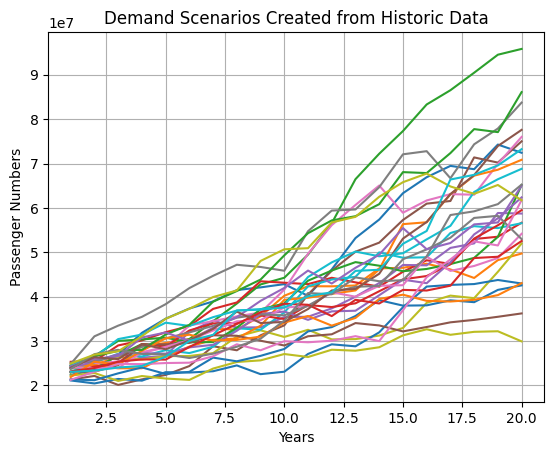

<Figure size 640x480 with 0 Axes>

In [57]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(mu, sigma, Dt0, dt, Fth, Forecasts)

# Round values up for further Calculation
D = np.ceil(Scenarios)
# print(D)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Fth,
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

# Need to define Capacity first!!

# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     K_rounded,
#     Fth,
#     True,
#     "Capacity",
#     "USD in Millions",
#     30,
# )

# print(np.shape(Scenarios))
# print(Scenarios)

Geometric Brownian motion Formula

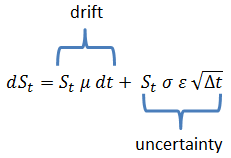

## Estimation of Dockstand Demand

In [58]:
# Percentage of Pax using Dock Stands rather than Bus Gates
p_dock = 0.8
# Percentage of Pax travelling within Schengen Area
p_schengen = 0.8
# Percentage of Pax travelling from Dock
p_Dok_A_B = 0.5
# average number of passengers carried per air traffic movement
PAXATM = 114

# Demand at design Hour
D_per_hour = D / (365 * 17)

# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM

# print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

In [59]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     d,
#     Fth,
#     True,
#     "Dockstand Demand Terminal A at ZRH",
#     "Number of Dock Stands",
#     30,
# )

## Calulation of the NPV
 #Check if greater, less, equal is correct!!!

In [60]:
def Capacity(K0, delta_K):
    # Create a cumulative sum array starting from K0
    K = K0 + np.cumsum(delta_K)
    return K


# delta_K = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0])
delta_K = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0])
K_rounded = Capacity(25, delta_K)
print("K_rounded: ", K_rounded)

K_rounded:  [25 25 25 25 30 30 30 30 30 40 40 40 40 40 50 50 50 50 50 50]


In [61]:
# def Revenue(K, D, r_K, r_K_rent, r_D):
#     # Check if greater, less, equal is correct!!!
#     diff = K - D
#     greater_zero = np.greater(diff, 0).astype(int)
#     less_equal_zero = np.less_equal(diff, 0).astype(int)
#     # if Overcapacity only amount of Demand can be sold
#     rev_overcapacity = greater_zero * (D * r_K + D * r_K_rent + D * r_D)
#     # if Undercapacity only available Capacity can be sold
#     rev_undercapacity = less_equal_zero * (K * r_K + K * r_K_rent + K * r_D)
#     Total_Revenue = rev_overcapacity + rev_undercapacity
#     return Total_Revenue


# def Revenue(K, D, r_K, r_K_rent, r_D):
#     diff = K - D
#     rev_overcapacity = (diff > 0) * (D * r_K + D * r_K_rent + D * r_D)
#     rev_undercapacity = (diff <= 0) * (K * r_K + K * r_K_rent + K * r_D)
#     Total_Revenue = rev_overcapacity + rev_undercapacity
#     return Total_Revenue


def Revenue(K, D, r_K, r_K_rent, r_D):
    diff = K - D
    # Calculate revenue for overcapacity
    rev_overcapacity = (diff > 0) * (D * r_K + D * r_K_rent + D * r_D)
    # Calculate revenue for undercapacity
    rev_undercapacity = (diff <= 0) * (K * r_K + K * r_K_rent + K * r_D)
    Total_Revenue = rev_overcapacity + rev_undercapacity
    return Total_Revenue


# def Cost(K, D, d, EoS, ci_K, delta_K0, h, co_D, co_K):
#     # Creation of a Capacity Change Vector
#     delta_K0 = np.diff(K)
#     # Setting the initial Value of the Change Vector to Zero
#     delta_K = np.insert(delta_K0, 0, 0)
#     # Penalty Cost Overcapacity
#     pc_over = 0.1
#     # Penalty Cost Undercapacity
#     pc_under = 0.1
#     # Calculate the Difference Matrix
#     diff = K - D
#     # Create an Index Matrix with the Condition for undercapacity
#     cos_overcapacity = np.greater(diff, 0).astype(int)
#     cos_undercapacity = np.less(diff, 0).astype(int)
#     cos_equalcapacity = np.equal(diff, 0).astype(int)

#     Total_Cost = (
#         ((ci_K * delta_K**EoS) / h)
#         + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
#         + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
#         + cos_equalcapacity * (co_D * D + co_K * K)
#     )
#     return Total_Cost


def Cost(K, D, d, EoS, ci_K, delta_K0, h, co_D, co_K):
    # Creation of a Capacity Change Vector
    delta_K0 = np.diff(K)
    # Setting the initial Value of the Change Vector to Zero
    delta_K = np.insert(delta_K0, 0, 0)
    # Penalty Cost Overcapacity
    pc_over = 1
    # Penalty Cost Undercapacity
    pc_under = 0.1
    # Calculate the Difference Matrix
    diff = K - D

    # Define coefficients for different scenarios
    undercapacity_coeff = pc_under + (co_D * K + co_K * K)
    overcapacity_coeff = pc_over + (co_D * D + co_K * D)
    equalcapacity_coeff = co_D * D + co_K * K

    # Calculate total cost without boolean expressions
    Total_Cost = (
        ((ci_K * delta_K**EoS) / h)
        + (diff < 0) * undercapacity_coeff
        + (diff > 0) * overcapacity_coeff
        + (diff == 0) * equalcapacity_coeff
    )
    return Total_Cost


def NPV_calculation(Revenue, Cost, discount):
    t = np.arange(0, Fth, dt)
    Profit = Revenue - Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    return NPV

In [62]:
# Paremeters:
r_D = 2  # Revenues per Unit of Demand per Period
r_K = 0.1  # Revenues per Unit of Capacity per Period
r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
co_K = 1  # Operational costs per unit of capacity per period
co_D = 1  # Operational cost per unit of demand per period
ci_K = 3  # Installation cost per unit of capacity
discount = 0.05  # Discount factor
EoS = 0.85  # EoS factor
delta_K0 = 0
h = 1
K0 = 25

D_rounded = np.ceil(D / 1000000)
D = D_rounded


def NPV_Genetic(delta_K):

    # K = K0 + np.cumsum(delta_K)
    K = K_rounded

    # Revenue
    diff = K - D
    greater_zero = np.greater(diff, 0).astype(int)
    less_equal_zero = np.less_equal(diff, 0).astype(int)
    # if Overcapacity only amount of Demand can be sold
    rev_overcapacity = greater_zero * (D * r_K + D * r_K_rent + D * r_D)
    # if Undercapacity only available Capacity can be sold
    rev_undercapacity = less_equal_zero * (K * r_K + K * r_K_rent + K * r_D)
    Total_Revenue = rev_overcapacity + rev_undercapacity

    # Cost
    # Penalty Cost Overcapacity
    pc_over = 1
    # Penalty Cost Undercapacity
    pc_under = 0.1
    # Create an Index Matrix with the Condition for undercapacity
    cos_overcapacity = np.greater(diff, 0).astype(int)
    cos_undercapacity = np.less(diff, 0).astype(int)
    cos_equalcapacity = np.equal(diff, 0).astype(int)

    Total_Cost = (
        ((ci_K * (delta_K) ** EoS) / h)
        + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
        + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
        + cos_equalcapacity * (co_D * D + co_K * K)
    )

    t = np.arange(0, Fth, dt)
    Profit = Total_Revenue - Total_Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    ENPV = np.sum(NPV)

    return -ENPV  # We use negative ENPV to maximize

Optimization Algorithm

In [63]:
initial_vector = np.array(
    [0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]
)

import random
import numpy as np
from deap import base, creator, tools

# Define the bounds for the delta_K
Lower_Limit = 0
Upper_Limit = 5

# Create the DEAP framework
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define the attributes (genes) and their ranges
toolbox.register("attr_float", random.randint, Lower_Limit, Upper_Limit)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=20
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Define the evaluation function
def evaluate(individual):
    return (NPV_Genetic(individual),)


toolbox.register("evaluate", evaluate)

# Define the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register(
    "mutate", tools.mutUniformInt, low=Lower_Limit, up=Upper_Limit, indpb=0.2
)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the genetic algorithm
population = toolbox.population(n=50)
cxpb, mutpb, ngen = 0.5, 0.2, 10

# Perform the evolution
for gen in range(ngen):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

# Get the best individual
best_ind = tools.selBest(population, 1)[0]
print("Best individual:", best_ind)
print(
    "Best NPV:", -best_ind.fitness.values[0]
)  # Negate the fitness to get the actual NPV value

Best individual: [5 4 5 4 5 1 1 5 4 4 5 5 5 5 4 5 5 2 4 3]
Best NPV: -49548.19325895395


In [64]:
# th = 1000000  # Throughput Capacity per Unit of Capacity
# r_D = 2  # Revenues per Unit of Demand per Period
# r_K = 2  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 1  # Operational costs per unit of capacity per period
# co_D = 1  # Operational cost per unit of demand per period
# ci_K = 3  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.75  # EoS factor
# delta_K0 = 0
# h = 1

# Definition of a Capacity Vector
# K_rounded = np.array(
#     [25, 25, 25, 25, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50]
# )
# K_rounded = np.array(
#     [25, 25, 28, 28, 28, 30, 30, 30, 32, 33, 37, 37, 37, 40, 40, 40, 41, 41, 42, 45]
# )

# [Total_Revenue, diff, less_equal_zero]
Rev = Revenue(K_rounded, D_rounded, r_K, r_K_rent, r_D)
# print(Rev)

Cos = Cost(K_rounded, D_rounded, d, EoS, ci_K, delta_K0, h, co_D, co_K)
# # print(Cos)

NPV1 = NPV_calculation(Rev, Cos, discount)
# print(NPV1)

ENPV = sum(NPV1)
print("ENPV: ", ENPV)

# NPV2 = NPV_Genetic(delta_K)
# print("NPV: ", NPV2)

ENPV2 = NPV_Genetic(delta_K)
print("ENPV2: ", -ENPV2)

ENPV3 = NPV_Genetic(best_ind)
print("ENPV3: ", -ENPV3)
print("Best delta_K", best_ind)

New_Capacity_Vector = Capacity(25, best_ind)
# print(New_Capacity_Vector)

ENPV:  44401.10690952431
ENPV2:  44401.10690952435
ENPV3:  -49548.19325895395
Best delta_K [5 4 5 4 5 1 1 5 4 4 5 5 5 5 4 5 5 2 4 3]


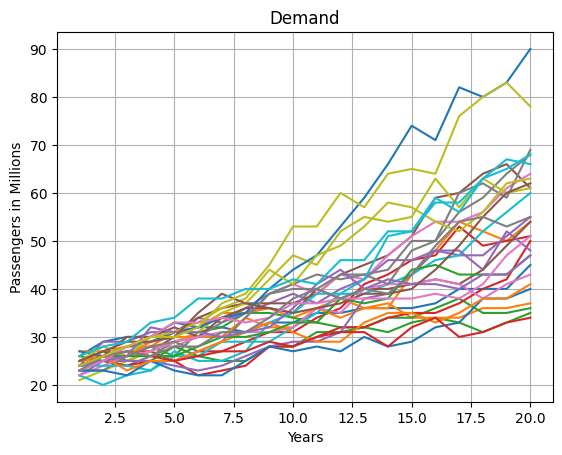

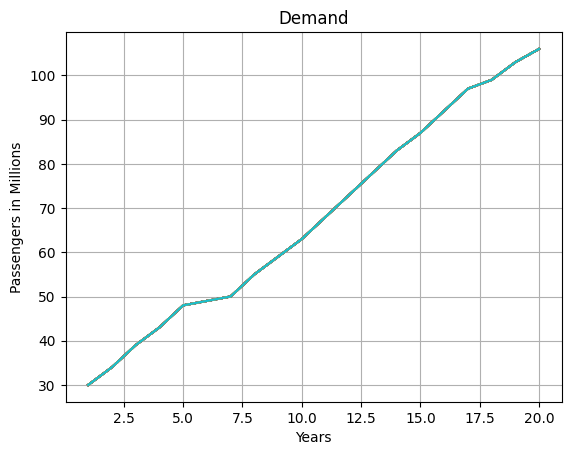

<Figure size 640x480 with 0 Axes>

In [65]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    D_rounded,
    Fth,
    True,
    "Demand",
    "Passengers in Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    New_Capacity_Vector,
    Fth,
    True,
    "Demand",
    "Passengers in Millions",
    30,
)

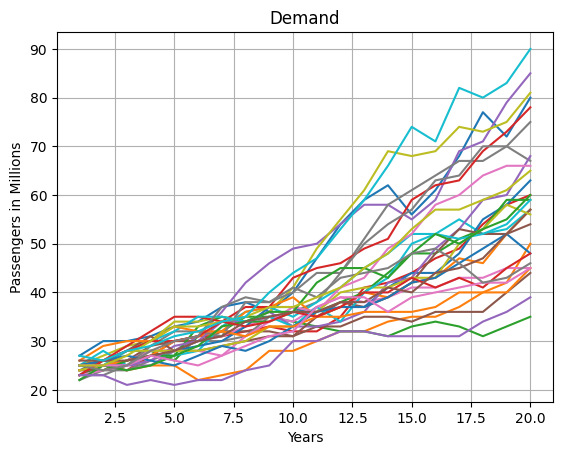

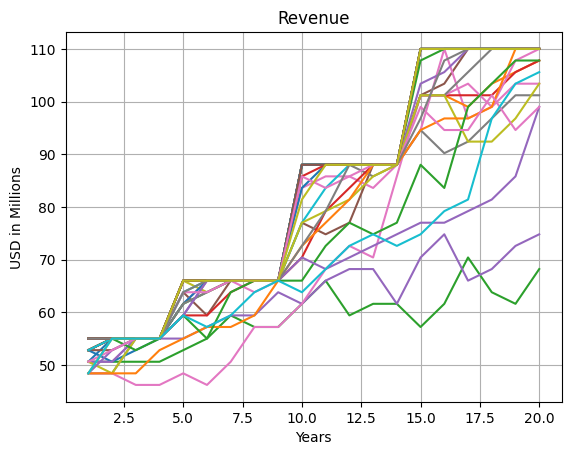

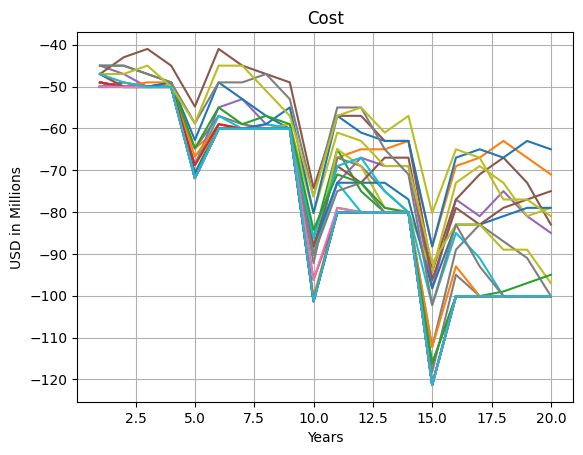

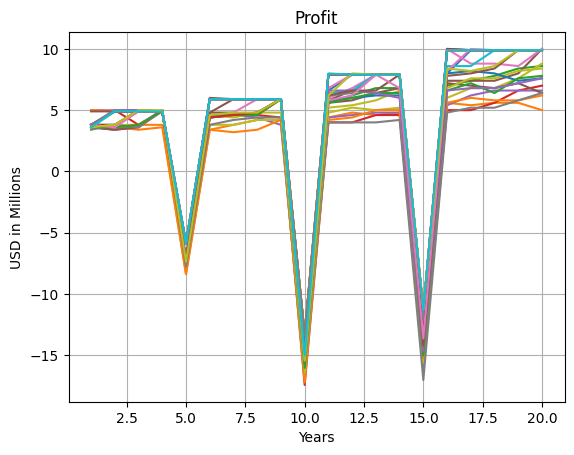

<Figure size 640x480 with 0 Axes>

In [66]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    D_rounded,
    Fth,
    True,
    "Demand",
    "Passengers in Millions",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev,
    Fth,
    True,
    "Revenue",
    "USD in Millions",
    30,
)


# Calling the Scenario Plotting Function


fn.Scenario_plot(
    -Cos,
    Fth,
    True,
    "Cost",
    "USD in Millions",
    30,
)


# Calling the Scenario Plotting Function


fn.Scenario_plot(
    Rev - Cos,
    Fth,
    True,
    "Profit",
    "USD in Millions",
    30,
)

In [67]:
# K_optimized = np.array(
#     [
#         25,
#         26,
#         27,
#         27,
#         29,
#         29,
#         30,
#         30,
#         32,
#         33,
#         37,
#         37,
#         37,
#         37,
#         40,
#         40,
#         41,
#         41,
#         42,
#         50,
#     ]
# )

# D_rounded = np.ceil(D / 1000000)

# Rev = Revenue(K_optimized, D_rounded, r_K, r_K_rent, r_D)

# Cos = Cost(K_optimized, D_rounded, d, EoS, ci_K, delta_K0, h, co_D, co_K)
# # print(Cos)

# NPV1 = NPV_calculation(Rev, Cos, discount)
# # print(NPV1)

# ENPV = sum(NPV1)
# print("ENPV: ", ENPV)

### Stopping the Runtime

In [68]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 2.1591286659240723
